In [2]:
import pandas as pd
import numpy as np
import os # Import the os module

# Create a synthetic dataset for the food recommendation system

# Define the number of users and food items
num_users = 500
num_food_items = 100

# Generate user data
user_ids = [f"U{i+1}" for i in range(num_users)]
user_ages = np.random.randint(18, 65, size=num_users)
user_genders = np.random.choice(["Male", "Female", "Other"], size=num_users)
user_preferences = np.random.choice(["Spicy", "Sweet", "Sour", "Savory", "Mixed"], size=num_users)

users_df = pd.DataFrame({
    "UserID": user_ids,
    "Age": user_ages,
    "Gender": user_genders,
    "Preference": user_preferences
})

# Generate food items data
food_ids = [f"F{i+1}" for i in range(num_food_items)]
food_names = [f"Food Item {i+1}" for i in range(num_food_items)]
food_categories = np.random.choice(["Appetizer", "Main Course", "Dessert", "Beverage"], size=num_food_items)
food_ingredients = np.random.choice(["Chicken", "Beef", "Vegetarian", "Seafood", "Pasta", "Rice"], size=num_food_items)
food_avg_ratings = np.round(np.random.uniform(3.0, 5.0, size=num_food_items), 1)
serving_size = np.random.randint(1, 4, size=num_food_items)  # Number of people the dish can serve

food_items_df = pd.DataFrame({
    "FoodID": food_ids,
    "Name": food_names,
    "Category": food_categories,
    "Ingredients": food_ingredients,
    "AverageRating": food_avg_ratings,
    "ServingSize": serving_size
})

# Generate user-food interactions (ratings)
num_interactions = 1000
interaction_user_ids = np.random.choice(user_ids, size=num_interactions)
interaction_food_ids = np.random.choice(food_ids, size=num_interactions)
interaction_ratings = np.random.randint(1, 6, size=num_interactions)  # Ratings from 1 to 5
people_count = np.random.randint(1, 4, size=num_interactions)  # Number of people sharing

interactions_df = pd.DataFrame({
    "UserID": interaction_user_ids,
    "FoodID": interaction_food_ids,
    "Rating": interaction_ratings,
    "PeopleCount": people_count
})

# Save the generated datasets to CSV files
users_file_path = "/mnt/data/users_data.csv"
food_items_file_path = "/mnt/data/food_items_data.csv"
interactions_file_path = "/mnt/data/interactions_data.csv"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(users_file_path), exist_ok=True)

users_df.to_csv(users_file_path, index=False)
food_items_df.to_csv(food_items_file_path, index=False)
interactions_df.to_csv(interactions_file_path, index=False)

users_file_path, food_items_file_path, interactions_file_path

('/mnt/data/users_data.csv',
 '/mnt/data/food_items_data.csv',
 '/mnt/data/interactions_data.csv')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

# Load the datasets
users_df = pd.read_csv(users_file_path)
food_items_df = pd.read_csv(food_items_file_path)
interactions_df = pd.read_csv(interactions_file_path)

# Data Preprocessing
# Merge interactions data with food items data to have user preferences along with food details
merged_df = interactions_df.merge(food_items_df, on="FoodID")

# Encode categorical features (e.g., Ingredients and Category)
label_encoder = LabelEncoder()
merged_df['Category'] = label_encoder.fit_transform(merged_df['Category'])
merged_df['Ingredients'] = label_encoder.fit_transform(merged_df['Ingredients'])

# Feature extraction for recommendation
features = merged_df[['Category', 'Ingredients', 'AverageRating', 'ServingSize', 'PeopleCount']]

# Prepare target labels (ratings)
ratings = merged_df['Rating']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, ratings, test_size=0.2, random_state=42)

# Create a content-based recommendation model using cosine similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(food_items_df['Ingredients'])

# Calculate cosine similarity between food items based on their ingredients
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get food recommendations
def get_recommendations(food_id, top_n=5):
    idx = food_items_df.index[food_items_df['FoodID'] == food_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    food_indices = [i[0] for i in sim_scores]
    return food_items_df.iloc[food_indices]

# Example usage
sample_food_id = 'F8'
recommended_foods = get_recommendations(sample_food_id)
recommended_foods


,FoodID,Name,Category,Ingredients,AverageRating,ServingSize
8,F9,Food Item 9,Main Course,Chicken,4.0,3
15,F16,Food Item 16,Main Course,Chicken,3.9,2
22,F23,Food Item 23,Main Course,Chicken,4.6,1
36,F37,Food Item 37,Beverage,Chicken,4.4,3
44,F45,Food Item 45,Main Course,Chicken,4.6,2


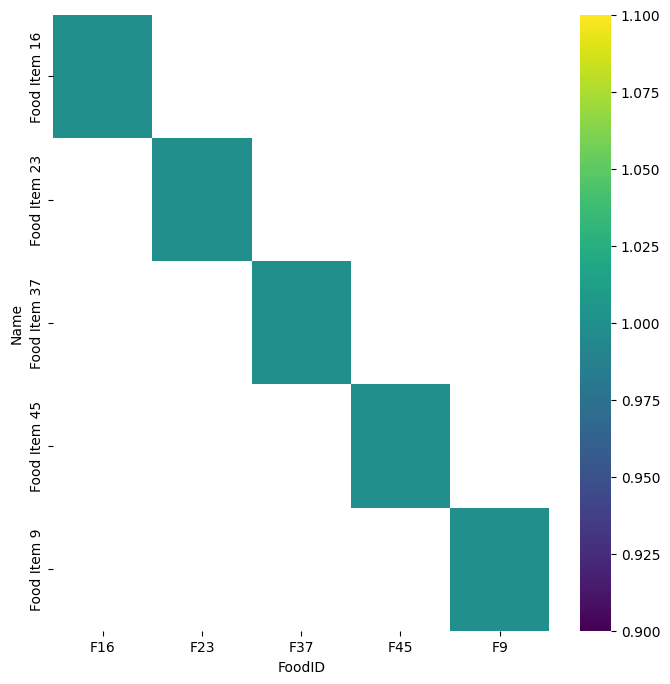

In [15]:
# @title FoodID vs Name

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Name'].value_counts()
    for x_label, grp in recommended_foods.groupby('FoodID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FoodID')
_ = plt.ylabel('Name')

In [11]:
import pandas as pd

def get_recommendations_by_user_preference(user_id, top_n=5):
  """
  Get food recommendations based on a user's preferences (e.g., age, gender, preference).

  Args:
    user_id: The ID of the user for whom to recommend foods.
    top_n: The number of recommendations to return.

  Returns:
    A DataFrame of recommended food items.
  """

  user_preferences = users_df[users_df['UserID'] == user_id][['Preference']].iloc[0]['Preference']

  # Filter food items based on the user's preference (e.g., Spicy, Sweet)
  # You might need to define a mapping of preferences to food item characteristics
  # For simplicity, we'll assume preference matches Ingredients directly.

  # Use a separate LabelEncoder for preferences
  preference_encoder = LabelEncoder()
  preference_encoder.fit(users_df['Preference']) # Fit on the 'Preference' column

  relevant_food_ids = merged_df[merged_df['Ingredients'] == preference_encoder.transform([user_preferences])[0]]['FoodID'].unique().tolist()

  if not relevant_food_ids:
    return pd.DataFrame()  # Return empty if no matching food found


  recommended_foods_for_user = food_items_df[food_items_df['FoodID'].isin(relevant_food_ids)]
  recommended_foods_for_user = recommended_foods_for_user.sort_values('AverageRating', ascending=False)

  return recommended_foods_for_user[['Name', 'Category', 'Ingredients', 'AverageRating', 'ServingSize']].head(top_n)


# Example usage: Recommend for a user based on preference
user_id = 'U10'
recommendations_by_user = get_recommendations_by_user_preference(user_id)

if not recommendations_by_user.empty:
  print(f"Recommendations for User {user_id}:")
  print(recommendations_by_user)
else:
  print(f"No recommendations found for user {user_id} based on their preferences.")

Recommendations for User U10:
            Name     Category Ingredients  AverageRating  ServingSize
53  Food Item 54    Appetizer     Chicken            4.7            3
44  Food Item 45  Main Course     Chicken            4.6            2
92  Food Item 93  Main Course     Chicken            4.6            3
22  Food Item 23  Main Course     Chicken            4.6            1
7    Food Item 8     Beverage     Chicken            4.4            1


In [7]:
# Update function to show the recipe name instead of food item number
def get_recommendations_by_name(food_name, top_n=5):
    idx = food_items_df.index[food_items_df['Name'] == food_name].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    food_indices = [i[0] for i in sim_scores]
    return food_items_df.iloc[food_indices][['Name', 'Category', 'Ingredients', 'AverageRating', 'ServingSize']]

# Example usage with food name
sample_food_name = 'Food Item 10'
recommended_foods_by_name = get_recommendations_by_name(sample_food_name)
recommended_foods_by_name


,Name,Category,Ingredients,AverageRating,ServingSize
5,Food Item 6,Beverage,Vegetarian,4.5,3
9,Food Item 10,Appetizer,Vegetarian,4.7,3
10,Food Item 11,Dessert,Vegetarian,3.4,2
12,Food Item 13,Beverage,Vegetarian,4.3,1
13,Food Item 14,Main Course,Vegetarian,3.9,1


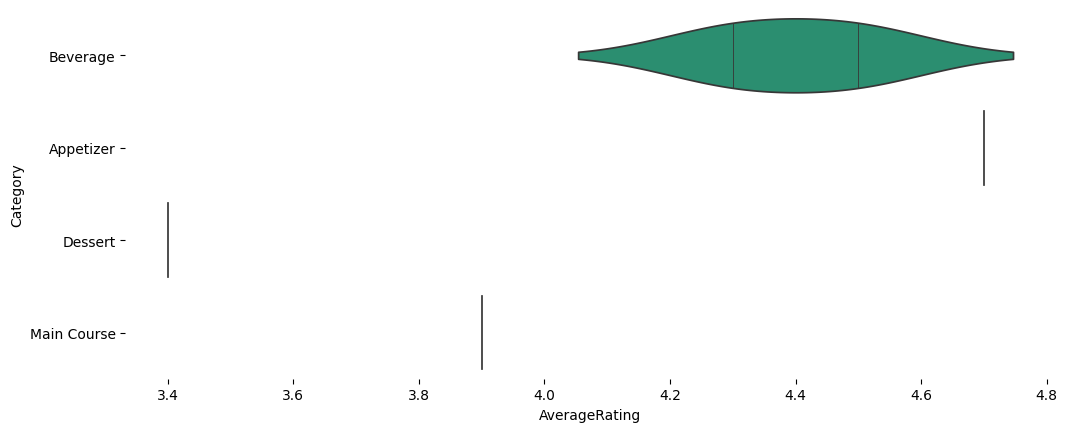

In [16]:
# @title Category vs AverageRating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(recommended_foods_by_name['Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(recommended_foods_by_name, x='AverageRating', y='Category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

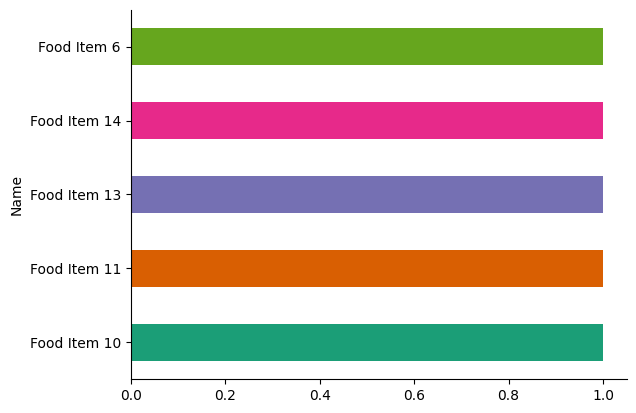

In [14]:
# @title Name

from matplotlib import pyplot as plt
import seaborn as sns
recommended_foods_by_name.groupby('Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

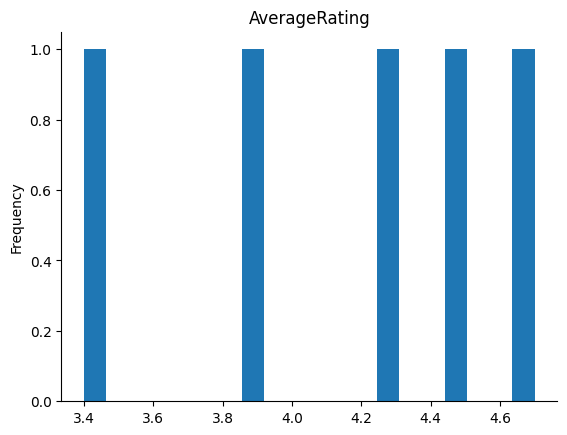

In [13]:
# @title AverageRating

from matplotlib import pyplot as plt
recommended_foods_by_name['AverageRating'].plot(kind='hist', bins=20, title='AverageRating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:

accuracy = (recommended_foods['AverageRating'] >= 4).mean()

print(recommended_foods['AverageRating'].describe())

print(f"Number of ratings >= 4: {(recommended_foods['AverageRating'] >= 4).sum()}")


count    5.000000
mean     4.300000
std      0.331662
min      3.900000
25%      4.000000
50%      4.400000
75%      4.600000
max      4.600000
Name: AverageRating, dtype: float64
Number of ratings >= 4: 4


new project
